######################################################
# Diabetes Prediction with Logistic Regression
######################################################

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin
# parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan
# Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal
# bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun
# pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Değişkenler
# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz.
# BloodPressure: Kan basıncı.
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


# 1. Exploratory Data Analysis
# 2. Data Preprocessing
# 3. Model & Prediction
# 4. Model Evaluation
# 5. Model Validation: Holdout
# 6. Model Validation: 10-Fold Cross Validation
# 7. Prediction for A New Observation

--------------------------------------------------------------

# Getting classes and modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate

# Methods for outliers and thresholds

In [2]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe[variable] = dataframe[variable].astype(float)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

######################################################
# Exploratory Data Analysis
######################################################

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

##########################
# Target'ın Analizi
##########################

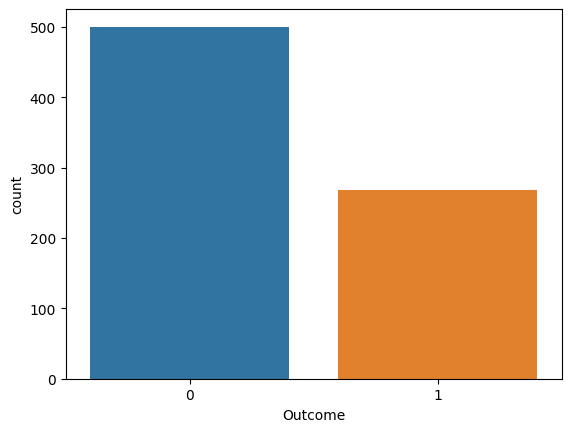

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

In [4]:
df["Outcome"].value_counts()

sns.countplot(x="Outcome", data=df)
plt.show()

100 * df["Outcome"].value_counts() / len(df)

##########################
# Feature'ların Analizi
##########################

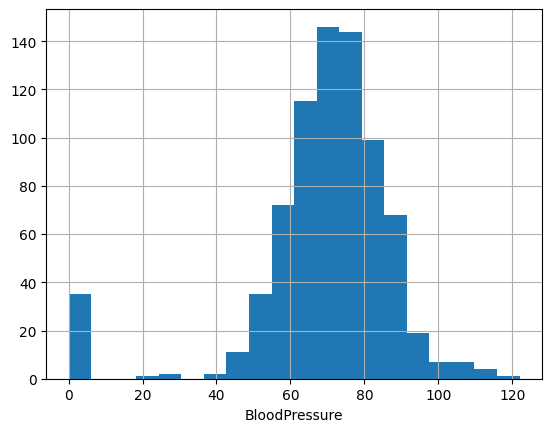

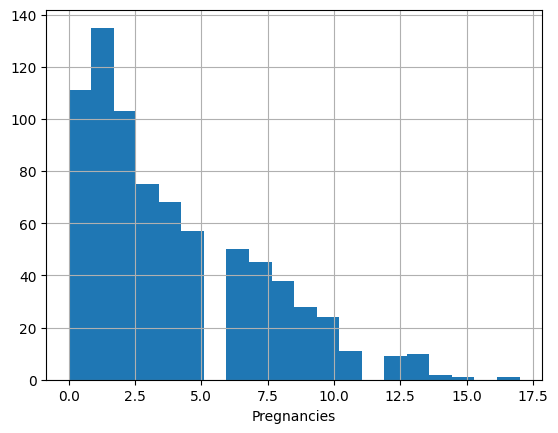

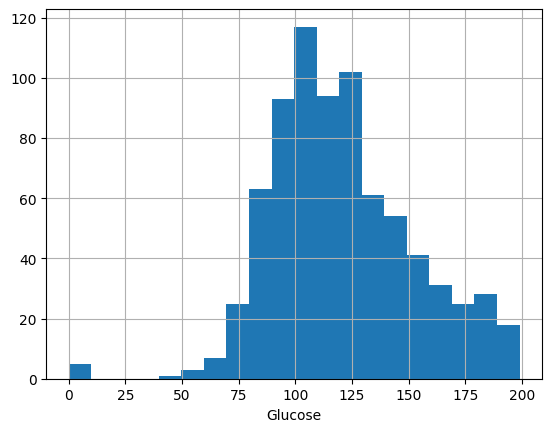

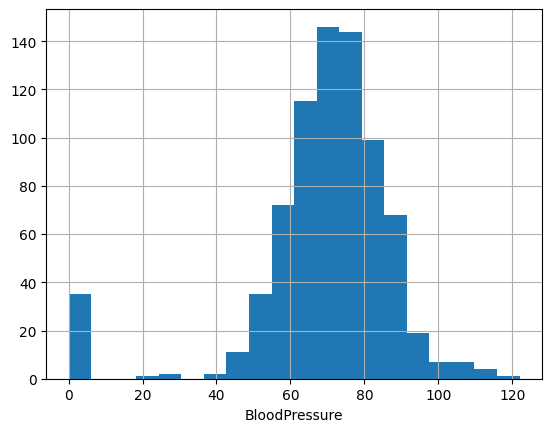

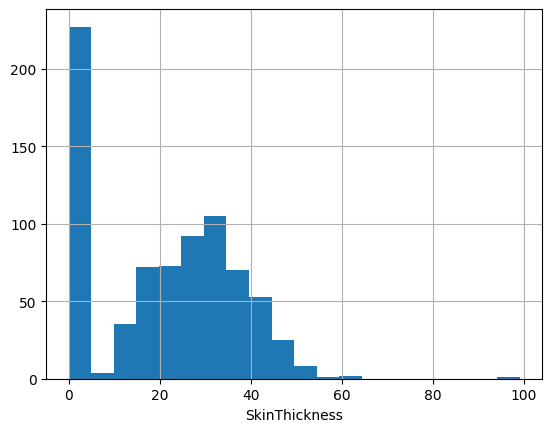

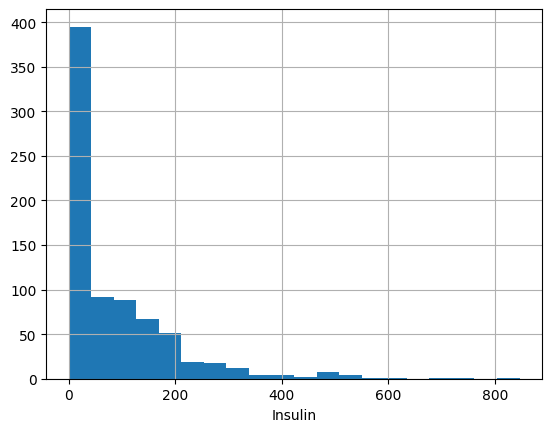

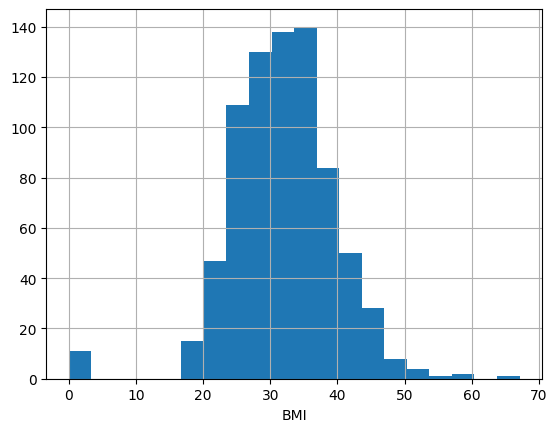

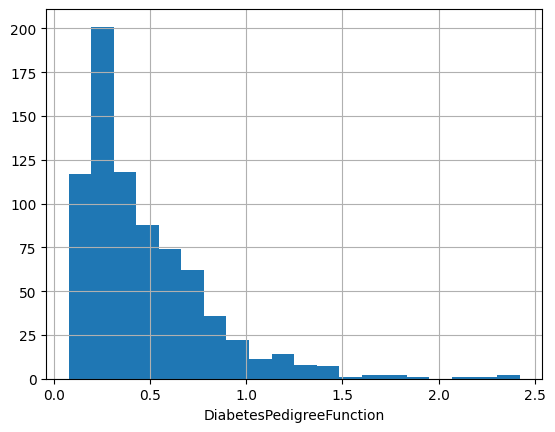

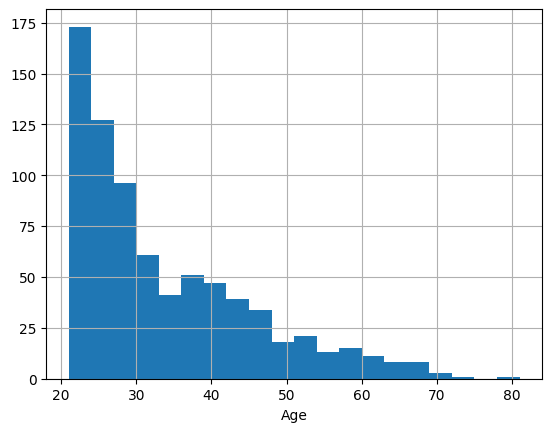

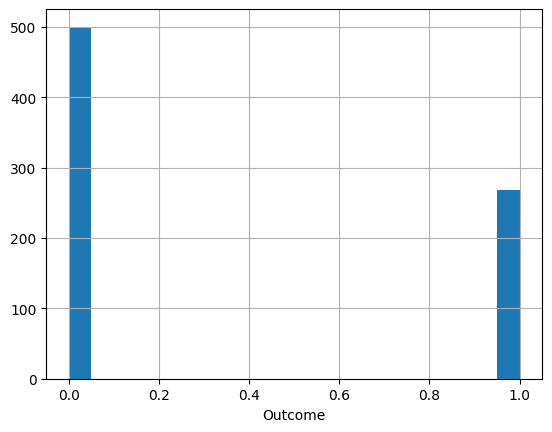

In [5]:

df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)


for col in df.columns:
    plot_numerical_col(df, col)

cols = [col for col in df.columns if "Outcome" not in col]

##########################
# Target vs Features
##########################

In [6]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




######################################################
# Data Preprocessing (Veri Ön İşleme)
######################################################

In [7]:
df.shape
df.head()

df.isnull().sum()

df.describe().T

for col in cols:
    print(col, check_outlier(df, col))

replace_with_thresholds(df, "Insulin")

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

df.head()

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


######################################################
# Model & Prediction
######################################################

In [8]:
y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)


In [9]:
log_model.intercept_

array([-1.23439588])

In [10]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [11]:
y_pred = log_model.predict(X)

y_pred[0:10]

y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

######################################################
# Model Evaluation
######################################################

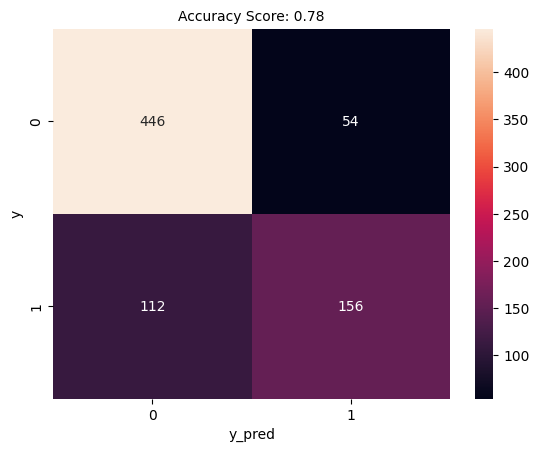

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



0.8393955223880598

In [12]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred))


# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)
# 0.83939

######################################################
# Model Validation: Holdout
######################################################

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



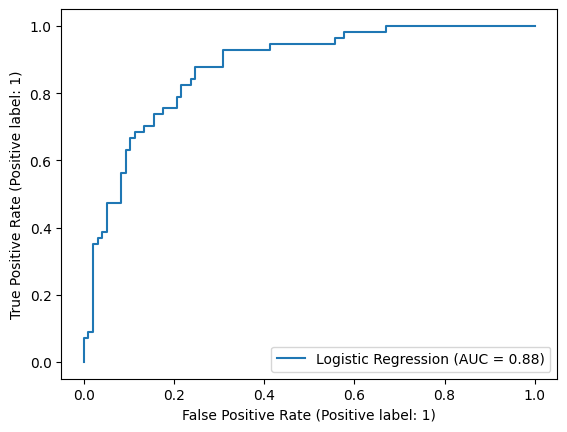

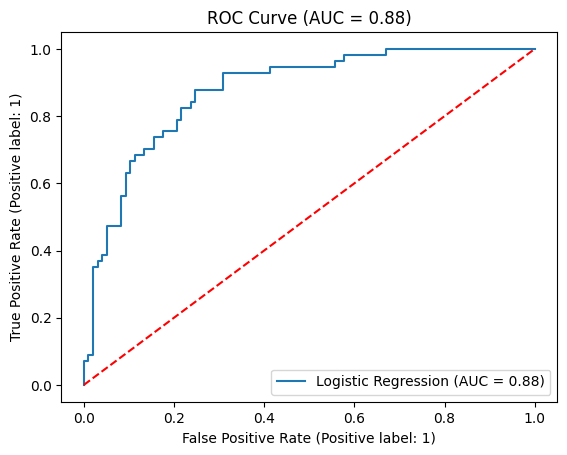

0.8755652016639537

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

roc_auc = roc_auc_score(y_test, y_prob)
display = RocCurveDisplay.from_estimator(log_model, X_test, y_test, name="Logistic Regression", ax=plt.gca())
display.plot()
plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# AUC
roc_auc_score(y_test, y_prob)

######################################################
# Model Validation: 10-Fold Cross Validation
######################################################

In [14]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])



# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63


cv_results['test_accuracy'].mean()
# Accuracy: 0.7721

cv_results['test_precision'].mean()
# Precision: 0.7192

cv_results['test_recall'].mean()
# Recall: 0.5747

cv_results['test_f1'].mean()
# F1-score: 0.6371

cv_results['test_roc_auc'].mean()
# AUC: 0.8327


0.8327295597484277

######################################################
# Prediction for A New Observation
######################################################

In [15]:
X.columns

random_user = X.sample(1, random_state=45)
log_model.predict(random_user)

array([1])